<br>

<h1 style="text-align:center;">Hyperparameter Search</h1>

<br>

## Initial Setup

---

In [1]:
import os
import itertools
import json
import wandb
from typing import Dict, Any
import copy
import signal
from train_ot2_rl import main as train_main

In [2]:
import wandb
wandb.tensorboard.patch(root_logdir="./runs")

<br>

## Hyperparameters to Search

---

In [3]:
# Base hyperparameters matching the training script
BASE_HYPERPARAMS = {
    # Learning parameters
    "learning_rate": 1e-4,
    "buffer_size": 100000,
    "batch_size": 256,
    "tau": 0.005,
    "gamma": 0.995,
    "train_freq": (1, "step"),
    "n_envs": 1,
    "gradient_steps": 1,
    
    # Architecture
    "actor_layers": [512, 512],
    "critic_layers": [512, 512],
    "activation_fn": "relu",
    "net_arch": "default",
    
    # Training
    "total_timesteps": 10_000,  # Reduced for search
    "learning_starts": 100,
    "ent_coef": "auto_1.0",
    
    # Environment
    "max_episode_steps": 500,
    "normalize_observations": True,
    "normalize_rewards": True,
    "reward_scale": 1.0,
    "clip_obs": 5.0,
    "clip_rewards": 5.0,
    
    # Evaluation
    "eval_freq": 10_000,  # Make sure we get at least one evaluation
    "n_eval_episodes": 5,
    "eval_deterministic": True
}

In [4]:
# Define parameter grid for search
PARAM_GRID = {
    "learning_rate": [3e-5, 1e-4, 3e-4],
    "max_episode_steps": [500, 1000, 2000],
    "buffer_size": [100000, 300000, 500000],
}

In [5]:
def generate_combinations() -> list:
    """Generate all combinations of hyperparameters to test."""
    keys = PARAM_GRID.keys()
    values = PARAM_GRID.values()
    combinations = list(itertools.product(*values))
    
    # Convert to list of dictionaries
    param_combinations = []
    for combo in combinations:
        params = dict(zip(keys, combo))
        # Create full config by updating base params
        full_config = copy.deepcopy(BASE_HYPERPARAMS)
        full_config.update(params)
        param_combinations.append(full_config)
    
    return param_combinations

In [6]:
# Define the hyperparameter search space
def create_hyperparameter_grid():
    """Create a simplified grid of hyperparameters to search"""
    return [
        {
            "learning_rate": lr,
            "buffer_size": bs,
            "max_episode_steps": 500  # Keep this constant
        }
        for lr in [3e-5, 1e-4, 3e-4]
        for bs in [100000, 300000]
    ]

<br>

## Run Trials

---

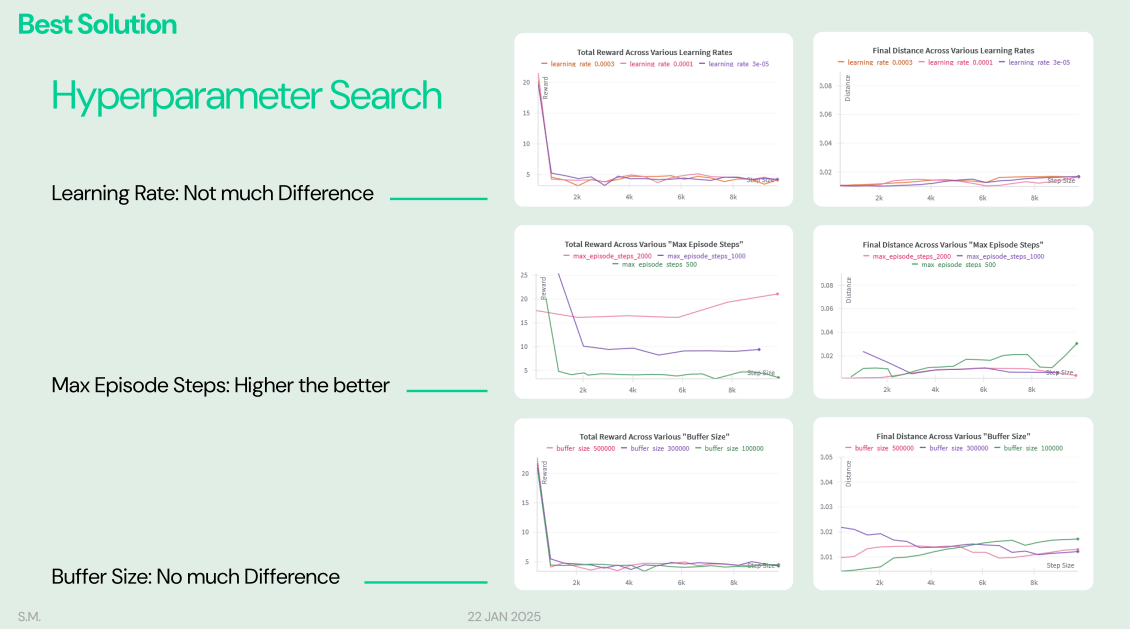

In [7]:
def run_trial(hyperparams, trial_num, param_name):
    """Modified trial runner to properly capture wandb metrics"""
    trial_dir = f'./trials/trial_{trial_num}'
    os.makedirs(trial_dir, exist_ok=True)
    
    try:
        # Initialize wandb with project name based on hyperparameter
        wandb.init(
            project=f"ot2_rl_hyperparameters_{param_name}",
            name=f"{param_name}_{hyperparams[param_name]}",
            config=hyperparams,
            sync_tensorboard=True,
            save_code=True,
        )
        
        # Run training and get the final evaluation reward
        final_eval_reward = train_main(custom_hyperparams=hyperparams, trial_dir=trial_dir)
        
        # Get the wandb run history
        if wandb.run is not None:
            history = wandb.run.history.rows
            if history:  # Get the last row of metrics
                last_metrics = history[-1]
                trial_results = {
                    'trial_num': trial_num,
                    'status': 'completed',
                    'final_distance_mm': last_metrics.get('distance/current', None),
                    'steps_taken': last_metrics.get('training/timesteps', None),
                    'min_distance': last_metrics.get('current/min_distance', None),
                    'episode_reward': last_metrics.get('current/episode_reward', None),
                    'distance_improvement': last_metrics.get('distance/improvement', None),
                    'steps_per_second': last_metrics.get('training/steps_per_second', None),
                }
            else:
                trial_results = {
                    'trial_num': trial_num,
                    'status': 'completed',
                    'final_distance_mm': final_eval_reward,
                    'steps_taken': hyperparams['total_timesteps']
                }
                
            # Save trial results to JSON
            with open(f'{trial_dir}/results.json', 'w') as f:
                json.dump(trial_results, f)
                
    except Exception as e:
        print(f"Error in trial {trial_num}: {str(e)}")
        # Record failed trial
        trial_results = {
            'trial_num': trial_num,
            'status': 'failed',
            'error': str(e)
        }
        with open(f'{trial_dir}/results.json', 'w') as f:
            json.dump(trial_results, f)
    
    finally:
        if wandb.run is not None:
            wandb.finish()

In [1]:
def main():
    """Run hyperparameter search."""
    # Generate parameter combinations
    param_combinations = generate_combinations()
    
    # Create trials directory
    os.makedirs('./trials', exist_ok=True)
    
    # Run trials for each hyperparameter separately
    for param_name in PARAM_GRID.keys():
        print(f"\nRunning trials for {param_name}")
        
        # Filter combinations to vary only this parameter
        base_params = copy.deepcopy(BASE_HYPERPARAMS)
        trial_num = 1
        
        for value in PARAM_GRID[param_name]:
            params = copy.deepcopy(base_params)
            params[param_name] = value
            
            print(f"\nStarting trial {trial_num} for {param_name}={value}")
            
            # Clear any existing progress bars before starting new trial
            try:
                from tqdm import tqdm
                for inst in tqdm._instances:
                    inst.close()
                tqdm._instances.clear()
            except:
                pass
                
            run_trial(params, trial_num, param_name)
            trial_num += 1

if __name__ == "__main__":
    main()

pybullet build time: Nov 28 2023 23:52:03
2025-01-21 22:23:55.833071: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-21 22:23:55.848363: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737494635.864567  155608 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737494635.869826  155608 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 22:23:55.888287: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow bina


Running trials for learning_rate

Starting trial 1 for learning_rate=3e-05


wandb: Currently logged in as: soheil-mpg. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


2025-01-21 22:24:00.505183: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-21 22:24:00.514387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737494640.525949  155715 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737494640.529586  155715 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 22:24:00.541574: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Normalization stats loaded successfully
Previous best model loaded successfully
Logging to runs/1o282s52/SAC_85


Output()


╔══════════════════════════════════════════════════╗
║                Episode 2 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.015,   0.174,   0.169 ║
║Goal Position:            -0.014,   0.172,   0.161 ║
║Initial Distance (m):                       0.1266 ║
║Final Distance (m):                         0.0092 ║
║Distance Improvement (m):                   0.1174 ║
║Steps Taken:                                   501 ║
║Total Reward:                               428.61 ║
║Average Reward/Step:                          0.86 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 430      |
| time/              |          |
|    episodes        | 1        |
|    fps             | 41       |
|    t


╔══════════════════════════════════════════════════╗
║                Episode 3 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.003,   0.070,   0.172 ║
║Goal Position:            -0.000,   0.069,   0.173 ║
║Initial Distance (m):                       0.0936 ║
║Final Distance (m):                         0.0029 ║
║Distance Improvement (m):                   0.0907 ║
║Steps Taken:                                   501 ║
║Total Reward:                               459.28 ║
║Average Reward/Step:                          0.92 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 445       |
| time/              |           |
|    episodes        | 2         |
|    fps             | 37        |
|


╔══════════════════════════════════════════════════╗
║                Episode 4 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.137,   0.189,   0.228 ║
║Goal Position:             0.138,   0.187,   0.226 ║
║Initial Distance (m):                       0.1584 ║
║Final Distance (m):                         0.0032 ║
║Distance Improvement (m):                   0.1552 ║
║Steps Taken:                                   501 ║
║Total Reward:                               440.25 ║
║Average Reward/Step:                          0.88 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 444      |
| time/              |          |
|    episodes        | 3        |
|    fps             | 37       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 5 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.043,  -0.129,   0.289 ║
║Goal Position:            -0.040,  -0.127,   0.286 ║
║Initial Distance (m):                       0.2959 ║
║Final Distance (m):                         0.0049 ║
║Distance Improvement (m):                   0.2910 ║
║Steps Taken:                                   501 ║
║Total Reward:                               407.88 ║
║Average Reward/Step:                          0.81 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 435      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 36       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 6 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.004,   0.117,   0.249 ║
║Goal Position:             0.008,   0.119,   0.242 ║
║Initial Distance (m):                       0.1427 ║
║Final Distance (m):                         0.0078 ║
║Distance Improvement (m):                   0.1349 ║
║Steps Taken:                                   501 ║
║Total Reward:                               427.67 ║
║Average Reward/Step:                          0.85 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 434      |
| time/              |          |
|    episodes        | 5        |
|    fps             | 36       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 7 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.251,  -0.069,   0.169 ║
║Goal Position:             0.250,  -0.065,   0.127 ║
║Initial Distance (m):                       0.2359 ║
║Final Distance (m):                         0.0430 ║
║Distance Improvement (m):                   0.1929 ║
║Steps Taken:                                   501 ║
║Total Reward:                               297.66 ║
║Average Reward/Step:                          0.59 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 411       |
| time/              |           |
|    episodes        | 6         |
|    fps             | 37        |
|


╔══════════════════════════════════════════════════╗
║                Episode 8 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.207,   0.163,   0.169 ║
║Goal Position:             0.204,   0.165,   0.167 ║
║Initial Distance (m):                       0.1587 ║
║Final Distance (m):                         0.0041 ║
║Distance Improvement (m):                   0.1545 ║
║Steps Taken:                                   501 ║
║Total Reward:                               426.37 ║
║Average Reward/Step:                          0.85 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 413       |
| time/              |           |
|    episodes        | 7         |
|    fps             | 36        |
|


╔══════════════════════════════════════════════════╗
║                Episode 9 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.253,  -0.132,   0.169 ║
║Goal Position:             0.249,  -0.125,   0.161 ║
║Initial Distance (m):                       0.2812 ║
║Final Distance (m):                         0.0115 ║
║Distance Improvement (m):                   0.2697 ║
║Steps Taken:                                   501 ║
║Total Reward:                               391.55 ║
║Average Reward/Step:                          0.78 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 411       |
| time/              |           |
|    episodes        | 8         |
|    fps             | 37        |
|


╔══════════════════════════════════════════════════╗
║                Episode 10 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.131,   0.067,   0.290 ║
║Goal Position:            -0.132,   0.073,   0.289 ║
║Initial Distance (m):                       0.2668 ║
║Final Distance (m):                         0.0058 ║
║Distance Improvement (m):                   0.2610 ║
║Steps Taken:                                   501 ║
║Total Reward:                               394.56 ║
║Average Reward/Step:                          0.79 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 409       |
| time/              |           |
|    episodes        | 9         |
|    fps             | 37        |
|


╔══════════════════════════════════════════════════╗
║                Episode 11 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.203,  -0.158,   0.277 ║
║Goal Position:             0.200,  -0.148,   0.270 ║
║Initial Distance (m):                       0.3094 ║
║Final Distance (m):                         0.0122 ║
║Distance Improvement (m):                   0.2971 ║
║Steps Taken:                                   501 ║
║Total Reward:                               381.89 ║
║Average Reward/Step:                          0.76 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 406       |
| time/              |           |
|    episodes        | 10        |
|    fps             | 35        |
|


╔══════════════════════════════════════════════════╗
║                Episode 12 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.098,  -0.104,   0.289 ║
║Goal Position:             0.096,  -0.092,   0.284 ║
║Initial Distance (m):                       0.2468 ║
║Final Distance (m):                         0.0129 ║
║Distance Improvement (m):                   0.2339 ║
║Steps Taken:                                   501 ║
║Total Reward:                               385.30 ║
║Average Reward/Step:                          0.77 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 405       |
| time/              |           |
|    episodes        | 11        |
|    fps             | 35        |
|


╔══════════════════════════════════════════════════╗
║                Episode 13 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.000,  -0.064,   0.169 ║
║Goal Position:            -0.001,  -0.053,   0.160 ║
║Initial Distance (m):                       0.1664 ║
║Final Distance (m):                         0.0139 ║
║Distance Improvement (m):                   0.1526 ║
║Steps Taken:                                   501 ║
║Total Reward:                               400.10 ║
║Average Reward/Step:                          0.80 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 404       |
| time/              |           |
|    episodes        | 12        |
|    fps             | 35        |
|


╔══════════════════════════════════════════════════╗
║                Episode 14 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.032,  -0.114,   0.289 ║
║Goal Position:            -0.031,  -0.101,   0.288 ║
║Initial Distance (m):                       0.2752 ║
║Final Distance (m):                         0.0130 ║
║Distance Improvement (m):                   0.2622 ║
║Steps Taken:                                   501 ║
║Total Reward:                               379.04 ║
║Average Reward/Step:                          0.76 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 402       |
| time/              |           |
|    episodes        | 13        |
|    fps             | 35        |
|


╔══════════════════════════════════════════════════╗
║                Episode 15 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.117,  -0.165,   0.169 ║
║Goal Position:             0.117,  -0.150,   0.159 ║
║Initial Distance (m):                       0.2473 ║
║Final Distance (m):                         0.0186 ║
║Distance Improvement (m):                   0.2286 ║
║Steps Taken:                                   501 ║
║Total Reward:                               363.45 ║
║Average Reward/Step:                          0.73 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 400       |
| time/              |           |
|    episodes        | 14        |
|    fps             | 35        |
|


╔══════════════════════════════════════════════════╗
║                Episode 16 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.019,   0.112,   0.217 ║
║Goal Position:             0.020,   0.124,   0.208 ║
║Initial Distance (m):                       0.1086 ║
║Final Distance (m):                         0.0154 ║
║Distance Improvement (m):                   0.0933 ║
║Steps Taken:                                   501 ║
║Total Reward:                               405.40 ║
║Average Reward/Step:                          0.81 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 400       |
| time/              |           |
|    episodes        | 15        |
|    fps             | 35        |
|


╔══════════════════════════════════════════════════╗
║                Episode 17 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.056,   0.013,   0.190 ║
║Goal Position:            -0.052,   0.023,   0.182 ║
║Initial Distance (m):                       0.1556 ║
║Final Distance (m):                         0.0135 ║
║Distance Improvement (m):                   0.1421 ║
║Steps Taken:                                   501 ║
║Total Reward:                               404.17 ║
║Average Reward/Step:                          0.81 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 400       |
| time/              |           |
|    episodes        | 16        |
|    fps             | 36        |
|


╔══════════════════════════════════════════════════╗
║                Episode 18 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.137,  -0.133,   0.225 ║
║Goal Position:            -0.130,  -0.120,   0.216 ║
║Initial Distance (m):                       0.3074 ║
║Final Distance (m):                         0.0174 ║
║Distance Improvement (m):                   0.2899 ║
║Steps Taken:                                   501 ║
║Total Reward:                               368.61 ║
║Average Reward/Step:                          0.74 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 399       |
| time/              |           |
|    episodes        | 17        |
|    fps             | 35        |
|


╔══════════════════════════════════════════════════╗
║                Episode 19 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.018,  -0.105,   0.169 ║
║Goal Position:            -0.011,  -0.092,   0.162 ║
║Initial Distance (m):                       0.2053 ║
║Final Distance (m):                         0.0167 ║
║Distance Improvement (m):                   0.1887 ║
║Steps Taken:                                   501 ║
║Total Reward:                               381.62 ║
║Average Reward/Step:                          0.76 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 398       |
| time/              |           |
|    episodes        | 18        |
|    fps             | 35        |
|


╔══════════════════════════════════════════════════╗
║                Episode 20 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.044,  -0.105,   0.289 ║
║Goal Position:             0.049,  -0.090,   0.282 ║
║Initial Distance (m):                       0.2442 ║
║Final Distance (m):                         0.0172 ║
║Distance Improvement (m):                   0.2270 ║
║Steps Taken:                                   501 ║
║Total Reward:                               370.01 ║
║Average Reward/Step:                          0.74 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 396       |
| time/              |           |
|    episodes        | 19        |
|    fps             | 35        |
|

╔══════════════════════════════════════════════════╗

1o282s52/SAC_85/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
1o282s52/SAC_85/rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
1o282s52/SAC_85/rollout/ep_rew_mean,▆██▇▆▃▃▃▃▂▂▂▂▁▂▂▁▁▁
1o282s52/SAC_85/time/fps,█▃▃▂▂▃▂▃▃▁▁▁▁▁▁▂▁▁▁
1o282s52/SAC_85/train/actor_loss,▅▄█▆▆▃▃▁▃▃▄▂▄▃▃▁▄▃▂
1o282s52/SAC_85/train/critic_loss,█▄▁▃▂▆▆▁▁▁▃▁▁▁▁▃▁▁▁
1o282s52/SAC_85/train/ent_coef,▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇██
1o282s52/SAC_85/train/ent_coef_loss,▇██▇▆▆▄▄▃▂▃▂▂▂▁▁▁▁▁
1o282s52/SAC_85/train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
current/episode_reward,█▂▃▂▂▂▁▃▃▁▁▃▁▁▂▁▁▂▁▁▂▂▂▁▃▂▂▂▂▂▁▂▁▂▂▂▁▂▂▃
current/episode_step,▃▄▆▃▄▇▄█▂▄▄▂▃▁▇▂█▁▅▇▃▆▇▁▃▅▅▆▆▁▁▄▆▂▄▅█▁▆▄



Starting trial 2 for learning_rate=0.0001


2025-01-21 22:28:46.537125: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2334: UserWarning: Run (byawwrno) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
2025-01-21 22:28:46.547784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737494926.560050  156557 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:0

Normalization stats loaded successfully


/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (byawwrno) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),


Previous best model loaded successfully
Logging to runs/1o282s52/SAC_86


Output()


╔══════════════════════════════════════════════════╗
║                Episode 2 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.030,  -0.093,   0.235 ║
║Goal Position:             0.030,  -0.090,   0.234 ║
║Initial Distance (m):                       0.2177 ║
║Final Distance (m):                         0.0039 ║
║Distance Improvement (m):                   0.2138 ║
║Steps Taken:                                   501 ║
║Total Reward:                               424.60 ║
║Average Reward/Step:                          0.85 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 426      |
| time/              |          |
|    episodes        | 1        |
|    fps             | 48       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 3 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.121,  -0.089,   0.128 ║
║Goal Position:            -0.117,  -0.082,   0.126 ║
║Initial Distance (m):                       0.2563 ║
║Final Distance (m):                         0.0084 ║
║Distance Improvement (m):                   0.2479 ║
║Steps Taken:                                   501 ║
║Total Reward:                               409.76 ║
║Average Reward/Step:                          0.82 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 418       |
| time/              |           |
|    episodes        | 2         |
|    fps             | 44        |
|


╔══════════════════════════════════════════════════╗
║                Episode 4 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.099,  -0.148,   0.187 ║
║Goal Position:             0.103,  -0.138,   0.185 ║
║Initial Distance (m):                       0.2398 ║
║Final Distance (m):                         0.0102 ║
║Distance Improvement (m):                   0.2295 ║
║Steps Taken:                                   501 ║
║Total Reward:                               392.64 ║
║Average Reward/Step:                          0.78 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 410      |
| time/              |          |
|    episodes        | 3        |
|    fps             | 40       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 5 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.167,   0.162,   0.283 ║
║Goal Position:            -0.160,   0.168,   0.278 ║
║Initial Distance (m):                       0.2926 ║
║Final Distance (m):                         0.0108 ║
║Distance Improvement (m):                   0.2819 ║
║Steps Taken:                                   501 ║
║Total Reward:                               382.47 ║
║Average Reward/Step:                          0.76 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 403       |
| time/              |           |
|    episodes        | 4         |
|    fps             | 40        |


╔══════════════════════════════════════════════════╗
║                Episode 6 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.125,   0.157,   0.169 ║
║Goal Position:             0.130,   0.161,   0.147 ║
║Initial Distance (m):                       0.0950 ║
║Final Distance (m):                         0.0233 ║
║Distance Improvement (m):                   0.0717 ║
║Steps Taken:                                   501 ║
║Total Reward:                               377.85 ║
║Average Reward/Step:                          0.75 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 398       |
| time/              |           |
|    episodes        | 5         |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 7 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.064,  -0.085,   0.169 ║
║Goal Position:             0.069,  -0.078,   0.139 ║
║Initial Distance (m):                       0.1695 ║
║Final Distance (m):                         0.0319 ║
║Distance Improvement (m):                   0.1376 ║
║Steps Taken:                                   501 ║
║Total Reward:                               337.88 ║
║Average Reward/Step:                          0.67 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 388       |
| time/              |           |
|    episodes        | 6         |
|    fps             | 40        |


╔══════════════════════════════════════════════════╗
║                Episode 8 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.074,   0.128,   0.215 ║
║Goal Position:            -0.068,   0.132,   0.215 ║
║Initial Distance (m):                       0.1755 ║
║Final Distance (m):                         0.0071 ║
║Distance Improvement (m):                   0.1684 ║
║Steps Taken:                                   501 ║
║Total Reward:                               393.39 ║
║Average Reward/Step:                          0.79 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 389       |
| time/              |           |
|    episodes        | 7         |
|    fps             | 40        |
|


╔══════════════════════════════════════════════════╗
║                Episode 9 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.043,   0.048,   0.201 ║
║Goal Position:            -0.036,   0.053,   0.200 ║
║Initial Distance (m):                       0.1410 ║
║Final Distance (m):                         0.0083 ║
║Distance Improvement (m):                   0.1326 ║
║Steps Taken:                                   501 ║
║Total Reward:                               429.15 ║
║Average Reward/Step:                          0.86 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 394       |
| time/              |           |
|    episodes        | 8         |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 10 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.127,   0.061,   0.175 ║
║Goal Position:            -0.119,   0.064,   0.174 ║
║Initial Distance (m):                       0.2012 ║
║Final Distance (m):                         0.0092 ║
║Distance Improvement (m):                   0.1920 ║
║Steps Taken:                                   501 ║
║Total Reward:                               408.07 ║
║Average Reward/Step:                          0.81 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 396       |
| time/              |           |
|    episodes        | 9         |
|    fps             | 40        |


╔══════════════════════════════════════════════════╗
║                Episode 11 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.011,  -0.095,   0.169 ║
║Goal Position:            -0.003,  -0.089,   0.137 ║
║Initial Distance (m):                       0.1948 ║
║Final Distance (m):                         0.0346 ║
║Distance Improvement (m):                   0.1602 ║
║Steps Taken:                                   501 ║
║Total Reward:                               323.44 ║
║Average Reward/Step:                          0.65 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 389       |
| time/              |           |
|    episodes        | 10        |
|    fps             | 40        |
|


╔══════════════════════════════════════════════════╗
║                Episode 12 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.045,  -0.109,   0.184 ║
║Goal Position:             0.052,  -0.101,   0.186 ║
║Initial Distance (m):                       0.2031 ║
║Final Distance (m):                         0.0114 ║
║Distance Improvement (m):                   0.1917 ║
║Steps Taken:                                   501 ║
║Total Reward:                               386.21 ║
║Average Reward/Step:                          0.77 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 389       |
| time/              |           |
|    episodes        | 11        |
|    fps             | 40        |


╔══════════════════════════════════════════════════╗
║                Episode 13 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.140,   0.167,   0.235 ║
║Goal Position:             0.145,   0.172,   0.235 ║
║Initial Distance (m):                       0.1591 ║
║Final Distance (m):                         0.0069 ║
║Distance Improvement (m):                   0.1523 ║
║Steps Taken:                                   501 ║
║Total Reward:                               420.01 ║
║Average Reward/Step:                          0.84 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 391       |
| time/              |           |
|    episodes        | 12        |
|    fps             | 40        |
|


╔══════════════════════════════════════════════════╗
║                Episode 14 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.135,   0.207,   0.125 ║
║Goal Position:             0.137,   0.209,   0.124 ║
║Initial Distance (m):                       0.1354 ║
║Final Distance (m):                         0.0034 ║
║Distance Improvement (m):                   0.1320 ║
║Steps Taken:                                   501 ║
║Total Reward:                               444.18 ║
║Average Reward/Step:                          0.89 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 395       |
| time/              |           |
|    episodes        | 13        |
|    fps             | 40        |
|


╔══════════════════════════════════════════════════╗
║                Episode 15 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.160,   0.128,   0.122 ║
║Goal Position:            -0.153,   0.130,   0.121 ║
║Initial Distance (m):                       0.2298 ║
║Final Distance (m):                         0.0066 ║
║Distance Improvement (m):                   0.2232 ║
║Steps Taken:                                   501 ║
║Total Reward:                               408.40 ║
║Average Reward/Step:                          0.82 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 396       |
| time/              |           |
|    episodes        | 14        |
|    fps             | 39        |


╔══════════════════════════════════════════════════╗
║                Episode 16 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.187,  -0.027,   0.289 ║
║Goal Position:            -0.185,  -0.025,   0.285 ║
║Initial Distance (m):                       0.3279 ║
║Final Distance (m):                         0.0052 ║
║Distance Improvement (m):                   0.3226 ║
║Steps Taken:                                   501 ║
║Total Reward:                               402.82 ║
║Average Reward/Step:                          0.80 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 397       |
| time/              |           |
|    episodes        | 15        |
|    fps             | 39        |
|


╔══════════════════════════════════════════════════╗
║                Episode 17 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.241,   0.009,   0.174 ║
║Goal Position:             0.246,   0.012,   0.170 ║
║Initial Distance (m):                       0.1964 ║
║Final Distance (m):                         0.0069 ║
║Distance Improvement (m):                   0.1895 ║
║Steps Taken:                                   501 ║
║Total Reward:                               397.18 ║
║Average Reward/Step:                          0.79 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 397       |
| time/              |           |
|    episodes        | 16        |
|    fps             | 40        |
|


╔══════════════════════════════════════════════════╗
║                Episode 18 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.174,  -0.146,   0.229 ║
║Goal Position:            -0.165,  -0.139,   0.224 ║
║Initial Distance (m):                       0.3463 ║
║Final Distance (m):                         0.0132 ║
║Distance Improvement (m):                   0.3331 ║
║Steps Taken:                                   501 ║
║Total Reward:                               372.29 ║
║Average Reward/Step:                          0.74 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 396       |
| time/              |           |
|    episodes        | 17        |
|    fps             | 39        |


╔══════════════════════════════════════════════════╗
║                Episode 19 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.240,   0.059,   0.245 ║
║Goal Position:             0.244,   0.065,   0.238 ║
║Initial Distance (m):                       0.2099 ║
║Final Distance (m):                         0.0100 ║
║Distance Improvement (m):                   0.1999 ║
║Steps Taken:                                   501 ║
║Total Reward:                               404.48 ║
║Average Reward/Step:                          0.81 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 396       |
| time/              |           |
|    episodes        | 18        |
|    fps             | 40        |
|


╔══════════════════════════════════════════════════╗
║                Episode 20 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.101,   0.180,   0.169 ║
║Goal Position:            -0.094,   0.183,   0.147 ║
║Initial Distance (m):                       0.1938 ║
║Final Distance (m):                         0.0233 ║
║Distance Improvement (m):                   0.1705 ║
║Steps Taken:                                   501 ║
║Total Reward:                               361.05 ║
║Average Reward/Step:                          0.72 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 394       |
| time/              |           |
|    episodes        | 19        |
|    fps             | 40        |

/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/stable_baselines3/common/save_util.py
:278: UserWarning: Path 'checkpoints/sac_model_replay_buffer_10000_steps.pkl' exists, will overwrite it.
  warnings.warn(f"Path '{path}' exists, will overwrite it.")

╔══════════════════════════════════════════════════╗

1o282s52/SAC_86/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
1o282s52/SAC_86/rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
1o282s52/SAC_86/rollout/ep_rew_mean,█▇▅▄▃▁▁▂▂▁▁▂▂▃▃▃▂▂▂
1o282s52/SAC_86/time/fps,█▅▂▂▃▂▂▃▂▂▂▂▂▁▁▂▁▂▂
1o282s52/SAC_86/train/actor_loss,█▅▄▄▄▄▃▃▂▂▂▂▁▁▂▁▁▁▁
1o282s52/SAC_86/train/critic_loss,▂▂▃▂▁▁▁▄█▃▁▁▃▁▁▃▁▁▁
1o282s52/SAC_86/train/ent_coef,▁▁▂▂▂▃▃▃▃▄▄▅▅▅▆▆▇▇█
1o282s52/SAC_86/train/ent_coef_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁
1o282s52/SAC_86/train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
current/episode_reward,▇█▁▂▂▁▂▂▁▂▃▁▁▁▂▁▂▂▂▃▂▂▃▁▂▂▁▁▃▂▁▂▂▂▂▁▂▁▁▃
current/episode_step,▂▃▅▆▇▁▂▂▄▅▅▇▆█▇▅▆█▁▂█▁▄▄▅▁▄▄█▃▄▆▁▅▆▂▃▅█▇



Starting trial 3 for learning_rate=0.0003


2025-01-21 22:33:12.087567: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2334: UserWarning: Run (byawwrno) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2334: UserWarning: Run (6r624zhq) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
2025-01-21 22:33:12.099137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.c

Normalization stats loaded successfully


/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (byawwrno) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (6r624zhq) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),


Previous best model loaded successfully
Logging to runs/1o282s52/SAC_87


Output()


╔══════════════════════════════════════════════════╗
║                Episode 2 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.112,   0.157,   0.247 ║
║Goal Position:             0.111,   0.156,   0.244 ║
║Initial Distance (m):                       0.1465 ║
║Final Distance (m):                         0.0032 ║
║Distance Improvement (m):                   0.1432 ║
║Steps Taken:                                   501 ║
║Total Reward:                               439.92 ║
║Average Reward/Step:                          0.88 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 441      |
| time/              |          |
|    episodes        | 1        |
|    fps             | 50       |
|    t


╔══════════════════════════════════════════════════╗
║                Episode 3 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.171,  -0.046,   0.211 ║
║Goal Position:             0.169,  -0.044,   0.207 ║
║Initial Distance (m):                       0.1877 ║
║Final Distance (m):                         0.0041 ║
║Distance Improvement (m):                   0.1836 ║
║Steps Taken:                                   501 ║
║Total Reward:                               436.41 ║
║Average Reward/Step:                          0.87 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 439      |
| time/              |          |
|    episodes        | 2        |
|    fps             | 37       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 4 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.217,  -0.160,   0.127 ║
║Goal Position:             0.212,  -0.153,   0.123 ║
║Initial Distance (m):                       0.2805 ║
║Final Distance (m):                         0.0082 ║
║Distance Improvement (m):                   0.2722 ║
║Steps Taken:                                   501 ║
║Total Reward:                               397.93 ║
║Average Reward/Step:                          0.79 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 426       |
| time/              |           |
|    episodes        | 3         |
|    fps             | 33        |
|


╔══════════════════════════════════════════════════╗
║                Episode 5 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.171,  -0.121,   0.169 ║
║Goal Position:             0.166,  -0.112,   0.128 ║
║Initial Distance (m):                       0.2227 ║
║Final Distance (m):                         0.0433 ║
║Distance Improvement (m):                   0.1794 ║
║Steps Taken:                                   501 ║
║Total Reward:                               300.51 ║
║Average Reward/Step:                          0.60 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 395       |
| time/              |           |
|    episodes        | 4         |
|    fps             | 30        |


╔══════════════════════════════════════════════════╗
║                Episode 6 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.111,  -0.114,   0.172 ║
║Goal Position:             0.107,  -0.102,   0.175 ║
║Initial Distance (m):                       0.2030 ║
║Final Distance (m):                         0.0132 ║
║Distance Improvement (m):                   0.1898 ║
║Steps Taken:                                   501 ║
║Total Reward:                               381.65 ║
║Average Reward/Step:                          0.76 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 392       |
| time/              |           |
|    episodes        | 5         |
|    fps             | 31        |
|


╔══════════════════════════════════════════════════╗
║                Episode 7 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.012,  -0.144,   0.169 ║
║Goal Position:             0.010,  -0.131,   0.147 ║
║Initial Distance (m):                       0.2312 ║
║Final Distance (m):                         0.0262 ║
║Distance Improvement (m):                   0.2050 ║
║Steps Taken:                                   501 ║
║Total Reward:                               340.00 ║
║Average Reward/Step:                          0.68 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 384       |
| time/              |           |
|    episodes        | 6         |
|    fps             | 31        |
|


╔══════════════════════════════════════════════════╗
║                Episode 8 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.014,   0.177,   0.270 ║
║Goal Position:             0.012,   0.186,   0.269 ║
║Initial Distance (m):                       0.1879 ║
║Final Distance (m):                         0.0094 ║
║Distance Improvement (m):                   0.1785 ║
║Steps Taken:                                   501 ║
║Total Reward:                               369.62 ║
║Average Reward/Step:                          0.74 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 382      |
| time/              |          |
|    episodes        | 7        |
|    fps             | 32       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 9 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.116,   0.129,   0.123 ║
║Goal Position:            -0.113,   0.135,   0.121 ║
║Initial Distance (m):                       0.1913 ║
║Final Distance (m):                         0.0066 ║
║Distance Improvement (m):                   0.1847 ║
║Steps Taken:                                   501 ║
║Total Reward:                               416.22 ║
║Average Reward/Step:                          0.83 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 386      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 32       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 10 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.193,  -0.026,   0.255 ║
║Goal Position:             0.193,  -0.020,   0.251 ║
║Initial Distance (m):                       0.2097 ║
║Final Distance (m):                         0.0073 ║
║Distance Improvement (m):                   0.2024 ║
║Steps Taken:                                   501 ║
║Total Reward:                               412.75 ║
║Average Reward/Step:                          0.82 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 389      |
| time/              |          |
|    episodes        | 9        |
|    fps             | 33       |
|    t


╔══════════════════════════════════════════════════╗
║                Episode 11 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.086,  -0.078,   0.197 ║
║Goal Position:             0.086,  -0.068,   0.193 ║
║Initial Distance (m):                       0.1750 ║
║Final Distance (m):                         0.0101 ║
║Distance Improvement (m):                   0.1649 ║
║Steps Taken:                                   501 ║
║Total Reward:                               416.26 ║
║Average Reward/Step:                          0.83 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 392      |
| time/              |          |
|    episodes        | 10       |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 12 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.092,   0.189,   0.229 ║
║Goal Position:             0.092,   0.193,   0.223 ║
║Initial Distance (m):                       0.1482 ║
║Final Distance (m):                         0.0073 ║
║Distance Improvement (m):                   0.1409 ║
║Steps Taken:                                   501 ║
║Total Reward:                               426.26 ║
║Average Reward/Step:                          0.85 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 395      |
| time/              |          |
|    episodes        | 11       |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 13 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.147,  -0.153,   0.276 ║
║Goal Position:            -0.143,  -0.144,   0.268 ║
║Initial Distance (m):                       0.3512 ║
║Final Distance (m):                         0.0126 ║
║Distance Improvement (m):                   0.3386 ║
║Steps Taken:                                   501 ║
║Total Reward:                               375.11 ║
║Average Reward/Step:                          0.75 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 394      |
| time/              |          |
|    episodes        | 12       |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 14 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.078,  -0.015,   0.215 ║
║Goal Position:             0.081,  -0.007,   0.207 ║
║Initial Distance (m):                       0.1314 ║
║Final Distance (m):                         0.0118 ║
║Distance Improvement (m):                   0.1195 ║
║Steps Taken:                                   501 ║
║Total Reward:                               417.88 ║
║Average Reward/Step:                          0.83 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 396      |
| time/              |          |
|    episodes        | 13       |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 15 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.217,  -0.096,   0.203 ║
║Goal Position:             0.217,  -0.086,   0.195 ║
║Initial Distance (m):                       0.2395 ║
║Final Distance (m):                         0.0131 ║
║Distance Improvement (m):                   0.2265 ║
║Steps Taken:                                   501 ║
║Total Reward:                               393.12 ║
║Average Reward/Step:                          0.78 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 395      |
| time/              |          |
|    episodes        | 14       |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 16 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.093,  -0.021,   0.169 ║
║Goal Position:             0.093,  -0.011,   0.136 ║
║Initial Distance (m):                       0.1046 ║
║Final Distance (m):                         0.0344 ║
║Distance Improvement (m):                   0.0702 ║
║Steps Taken:                                   501 ║
║Total Reward:                               339.59 ║
║Average Reward/Step:                          0.68 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 392      |
| time/              |          |
|    episodes        | 15       |
|    fps             | 32       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 17 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.047,   0.019,   0.269 ║
║Goal Position:             0.048,   0.027,   0.262 ║
║Initial Distance (m):                       0.1584 ║
║Final Distance (m):                         0.0107 ║
║Distance Improvement (m):                   0.1477 ║
║Steps Taken:                                   501 ║
║Total Reward:                               371.85 ║
║Average Reward/Step:                          0.74 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 391      |
| time/              |          |
|    episodes        | 16       |
|    fps             | 32       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 18 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.106,  -0.150,   0.280 ║
║Goal Position:             0.105,  -0.137,   0.271 ║
║Initial Distance (m):                       0.2757 ║
║Final Distance (m):                         0.0149 ║
║Distance Improvement (m):                   0.2608 ║
║Steps Taken:                                   501 ║
║Total Reward:                               371.52 ║
║Average Reward/Step:                          0.74 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 389      |
| time/              |          |
|    episodes        | 17       |
|    fps             | 32       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 19 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.132,  -0.064,   0.169 ║
║Goal Position:             0.131,  -0.052,   0.123 ║
║Initial Distance (m):                       0.1536 ║
║Final Distance (m):                         0.0481 ║
║Distance Improvement (m):                   0.1055 ║
║Steps Taken:                                   501 ║
║Total Reward:                               297.56 ║
║Average Reward/Step:                          0.59 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 384      |
| time/              |          |
|    episodes        | 18       |
|    fps             | 31       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 20 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.236,  -0.170,   0.252 ║
║Goal Position:             0.232,  -0.164,   0.245 ║
║Initial Distance (m):                       0.3251 ║
║Final Distance (m):                         0.0099 ║
║Distance Improvement (m):                   0.3152 ║
║Steps Taken:                                   501 ║
║Total Reward:                               357.60 ║
║Average Reward/Step:                          0.71 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 383      |
| time/              |          |
|    episodes        | 19       |
|    fps             | 31       |
|    tim

/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/stable_baselines3/common/save_util.py
:278: UserWarning: Path 'checkpoints/sac_model_replay_buffer_10000_steps.pkl' exists, will overwrite it.
  warnings.warn(f"Path '{path}' exists, will overwrite it.")

╔══════════════════════════════════════════════════╗

1o282s52/SAC_87/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
1o282s52/SAC_87/rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
1o282s52/SAC_87/rollout/ep_rew_mean,██▆▃▂▁▁▂▂▂▃▂▃▃▂▂▂▁▁
1o282s52/SAC_87/time/fps,█▃▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▁▁
1o282s52/SAC_87/train/actor_loss,█▅▃▂▁▂▃▄▄▄▅▅▅▅▅▆▆▆▆
1o282s52/SAC_87/train/critic_loss,█▆▂▃▂▂▃▁▁▂▁▂▁▁▁▁▁▁▁
1o282s52/SAC_87/train/ent_coef,▁▁▂▂▃▃▄▄▅▅▆▆▇▇████▇
1o282s52/SAC_87/train/ent_coef_loss,█▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
1o282s52/SAC_87/train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
current/episode_reward,▅▂▂▄▆▃▆▃▄▅▂▁▂▅▆█▂▃▇▂▅▆▃▁▃▃▆▇▂▅▆▄▄▁▃▁▃▄▁▂
current/episode_step,▂▅▂▃▃▄▄▃▄█▅▇▁▂▄▁▂▂▅▆▇▄▆▇▅▅▃▇▇▃█▄▄▇▄▆█▃▃▅



Running trials for max_episode_steps

Starting trial 1 for max_episode_steps=500


2025-01-21 22:38:49.648658: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2334: UserWarning: Run (byawwrno) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2334: UserWarning: Run (6r624zhq) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/

Normalization stats loaded successfully


/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (byawwrno) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (6r624zhq) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (won95vn6) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),


Previous best model loaded successfully
Logging to runs/1o282s52/SAC_88


Output()


╔══════════════════════════════════════════════════╗
║                Episode 2 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.169,  -0.000,   0.181 ║
║Goal Position:             0.168,   0.001,   0.180 ║
║Initial Distance (m):                       0.1439 ║
║Final Distance (m):                         0.0018 ║
║Distance Improvement (m):                   0.1422 ║
║Steps Taken:                                   501 ║
║Total Reward:                               453.83 ║
║Average Reward/Step:                          0.91 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 455      |
| time/              |          |
|    episodes        | 1        |
|    fps             | 31       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 3 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.135,   0.165,   0.203 ║
║Goal Position:             0.133,   0.165,   0.201 ║
║Initial Distance (m):                       0.1260 ║
║Final Distance (m):                         0.0029 ║
║Distance Improvement (m):                   0.1231 ║
║Steps Taken:                                   501 ║
║Total Reward:                               452.63 ║
║Average Reward/Step:                          0.90 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 454      |
| time/              |          |
|    episodes        | 2        |
|    fps             | 31       |
|    t


╔══════════════════════════════════════════════════╗
║                Episode 4 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.018,   0.100,   0.169 ║
║Goal Position:            -0.018,   0.100,   0.146 ║
║Initial Distance (m):                       0.0959 ║
║Final Distance (m):                         0.0230 ║
║Distance Improvement (m):                   0.0728 ║
║Steps Taken:                                   501 ║
║Total Reward:                               379.46 ║
║Average Reward/Step:                          0.76 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 430       |
| time/              |           |
|    episodes        | 3         |
|    fps             | 34        |
|


╔══════════════════════════════════════════════════╗
║                Episode 5 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.076,  -0.018,   0.255 ║
║Goal Position:             0.075,  -0.016,   0.253 ║
║Initial Distance (m):                       0.1706 ║
║Final Distance (m):                         0.0030 ║
║Distance Improvement (m):                   0.1676 ║
║Steps Taken:                                   501 ║
║Total Reward:                               405.21 ║
║Average Reward/Step:                          0.81 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 424       |
| time/              |           |
|    episodes        | 4         |
|    fps             | 32        |
|


╔══════════════════════════════════════════════════╗
║                Episode 6 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.074,   0.162,   0.281 ║
║Goal Position:             0.074,   0.162,   0.282 ║
║Initial Distance (m):                       0.1778 ║
║Final Distance (m):                         0.0009 ║
║Distance Improvement (m):                   0.1769 ║
║Steps Taken:                                   158 ║
║Total Reward:                               100.27 ║
║Average Reward/Step:                          0.63 ║
║Status:                            Goal Reached! 🎯 ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 433      |
|    ep_rew_mean     | 559      |
| time/              |          |
|    episodes        | 5        |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 7 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.007,  -0.036,   0.289 ║
║Goal Position:            -0.006,  -0.034,   0.288 ║
║Initial Distance (m):                       0.2243 ║
║Final Distance (m):                         0.0025 ║
║Distance Improvement (m):                   0.2218 ║
║Steps Taken:                                   501 ║
║Total Reward:                               427.47 ║
║Average Reward/Step:                          0.85 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 445      |
|    ep_rew_mean     | 537      |
| time/              |          |
|    episodes        | 6        |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 8 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.229,   0.066,   0.194 ║
║Goal Position:             0.227,   0.068,   0.185 ║
║Initial Distance (m):                       0.1692 ║
║Final Distance (m):                         0.0095 ║
║Distance Improvement (m):                   0.1597 ║
║Steps Taken:                                   501 ║
║Total Reward:                               414.37 ║
║Average Reward/Step:                          0.83 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 453      |
|    ep_rew_mean     | 520      |
| time/              |          |
|    episodes        | 7        |
|    fps             | 32       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 9 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.152,   0.089,   0.235 ║
║Goal Position:            -0.149,   0.090,   0.225 ║
║Initial Distance (m):                       0.2463 ║
║Final Distance (m):                         0.0106 ║
║Distance Improvement (m):                   0.2358 ║
║Steps Taken:                                   501 ║
║Total Reward:                               397.33 ║
║Average Reward/Step:                          0.79 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 459      |
|    ep_rew_mean     | 505      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 10 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.084,  -0.161,   0.172 ║
║Goal Position:             0.086,  -0.155,   0.164 ║
║Initial Distance (m):                       0.2491 ║
║Final Distance (m):                         0.0103 ║
║Distance Improvement (m):                   0.2388 ║
║Steps Taken:                                   501 ║
║Total Reward:                               390.89 ║
║Average Reward/Step:                          0.78 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 464       |
|    ep_rew_mean     | 492       |
| time/              |           |
|    episodes        | 9         |
|    fps             | 33        |
|


╔══════════════════════════════════════════════════╗
║                Episode 11 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.139,   0.058,   0.181 ║
║Goal Position:            -0.133,   0.064,   0.174 ║
║Initial Distance (m):                       0.2152 ║
║Final Distance (m):                         0.0106 ║
║Distance Improvement (m):                   0.2047 ║
║Steps Taken:                                   501 ║
║Total Reward:                               397.70 ║
║Average Reward/Step:                          0.79 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 468      |
|    ep_rew_mean     | 483      |
| time/              |          |
|    episodes        | 10       |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 12 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.091,  -0.080,   0.289 ║
║Goal Position:            -0.083,  -0.073,   0.283 ║
║Initial Distance (m):                       0.2788 ║
║Final Distance (m):                         0.0127 ║
║Distance Improvement (m):                   0.2661 ║
║Steps Taken:                                   501 ║
║Total Reward:                               386.42 ║
║Average Reward/Step:                          0.77 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 471      |
|    ep_rew_mean     | 474      |
| time/              |          |
|    episodes        | 11       |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 13 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.156,  -0.012,   0.169 ║
║Goal Position:             0.161,  -0.004,   0.143 ║
║Initial Distance (m):                       0.1314 ║
║Final Distance (m):                         0.0276 ║
║Distance Improvement (m):                   0.1038 ║
║Steps Taken:                                   501 ║
║Total Reward:                               357.02 ║
║Average Reward/Step:                          0.71 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 473       |
|    ep_rew_mean     | 464       |
| time/              |           |
|    episodes        | 12        |
|    fps             | 33        |
|


╔══════════════════════════════════════════════════╗
║                Episode 14 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.187,   0.148,   0.225 ║
║Goal Position:            -0.182,   0.153,   0.218 ║
║Initial Distance (m):                       0.2803 ║
║Final Distance (m):                         0.0098 ║
║Distance Improvement (m):                   0.2705 ║
║Steps Taken:                                   501 ║
║Total Reward:                               388.08 ║
║Average Reward/Step:                          0.77 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 476      |
|    ep_rew_mean     | 459      |
| time/              |          |
|    episodes        | 13       |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 15 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.220,  -0.081,   0.221 ║
║Goal Position:             0.224,  -0.074,   0.214 ║
║Initial Distance (m):                       0.2426 ║
║Final Distance (m):                         0.0112 ║
║Distance Improvement (m):                   0.2314 ║
║Steps Taken:                                   501 ║
║Total Reward:                               392.94 ║
║Average Reward/Step:                          0.78 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 478      |
|    ep_rew_mean     | 454      |
| time/              |          |
|    episodes        | 14       |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 16 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.174,   0.053,   0.169 ║
║Goal Position:            -0.166,   0.059,   0.131 ║
║Initial Distance (m):                       0.2414 ║
║Final Distance (m):                         0.0396 ║
║Distance Improvement (m):                   0.2019 ║
║Steps Taken:                                   501 ║
║Total Reward:                               297.75 ║
║Average Reward/Step:                          0.59 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 479      |
|    ep_rew_mean     | 444      |
| time/              |          |
|    episodes        | 15       |
|    fps             | 34       |
|    t


╔══════════════════════════════════════════════════╗
║                Episode 17 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.004,  -0.029,   0.267 ║
║Goal Position:             0.005,  -0.022,   0.260 ║
║Initial Distance (m):                       0.1928 ║
║Final Distance (m):                         0.0130 ║
║Distance Improvement (m):                   0.1798 ║
║Steps Taken:                                   501 ║
║Total Reward:                               357.58 ║
║Average Reward/Step:                          0.71 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 481      |
|    ep_rew_mean     | 438      |
| time/              |          |
|    episodes        | 16       |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 18 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.013,   0.011,   0.212 ║
║Goal Position:             0.019,   0.017,   0.206 ║
║Initial Distance (m):                       0.1256 ║
║Final Distance (m):                         0.0111 ║
║Distance Improvement (m):                   0.1146 ║
║Steps Taken:                                   501 ║
║Total Reward:                               421.27 ║
║Average Reward/Step:                          0.84 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 482       |
|    ep_rew_mean     | 437       |
| time/              |           |
|    episodes        | 17        |
|    fps             | 34        |


╔══════════════════════════════════════════════════╗
║                Episode 19 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.176,   0.198,   0.172 ║
║Goal Position:             0.179,   0.201,   0.166 ║
║Initial Distance (m):                       0.1604 ║
║Final Distance (m):                         0.0074 ║
║Distance Improvement (m):                   0.1531 ║
║Steps Taken:                                   501 ║
║Total Reward:                               422.45 ║
║Average Reward/Step:                          0.84 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 483      |
|    ep_rew_mean     | 437      |
| time/              |          |
|    episodes        | 18       |
|    fps             | 34       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 20 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.187,   0.101,   0.288 ║
║Goal Position:            -0.179,   0.104,   0.279 ║
║Initial Distance (m):                       0.2992 ║
║Final Distance (m):                         0.0116 ║
║Distance Improvement (m):                   0.2876 ║
║Steps Taken:                                   501 ║
║Total Reward:                               385.68 ║
║Average Reward/Step:                          0.77 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 484      |
|    ep_rew_mean     | 434      |
| time/              |          |
|    episodes        | 19       |
|    fps             | 34       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 21 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.090,   0.049,   0.169 ║
║Goal Position:            -0.079,   0.051,   0.131 ║
║Initial Distance (m):                       0.1577 ║
║Final Distance (m):                         0.0399 ║
║Distance Improvement (m):                   0.1178 ║
║Steps Taken:                                   501 ║
║Total Reward:                               313.20 ║
║Average Reward/Step:                          0.63 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 485       |
|    ep_rew_mean     | 428       |
| time/              |           |
|    episodes        | 20        |
|    fps             | 34        |
|

/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/stable_baselines3/common/save_util.py
:278: UserWarning: Path 'checkpoints/sac_model_replay_buffer_10000_steps.pkl' exists, will overwrite it.
  warnings.warn(f"Path '{path}' exists, will overwrite it.")

╔══════════════════════════════════════════════════╗

1o282s52/SAC_88/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
1o282s52/SAC_88/rollout/ep_len_mean,████▁▂▃▄▄▅▅▅▅▆▆▆▆▆▆▆
1o282s52/SAC_88/rollout/ep_rew_mean,▃▃▁▁█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁
1o282s52/SAC_88/time/fps,▁▁█▃▆▆▃▆▆▆▆▆▆▆█▆████
1o282s52/SAC_88/train/actor_loss,▆█▁▃▅█▆▆▄▂▇▄▆▆▆▇▅█▅▃
1o282s52/SAC_88/train/critic_loss,█▃▂▄▅▂▄▂▂▆▂▂▁▁▃▄▂▂▁▂
1o282s52/SAC_88/train/ent_coef,▁▁▁▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇██
1o282s52/SAC_88/train/ent_coef_loss,▇▄▇▇█▅▆▅▆▄▄▃▃▃▂▂▂▂▁▁
1o282s52/SAC_88/train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
current/episode_reward,▅▇█▁▁▁▁▁▂▁▁▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▂▁▂▂▂▂▁▂▂▁▂▁▁
current/episode_step,▁▅█▁▆▅▆▆▇▄▅█▅▇█▁▇▄▆▃▃▄▄▆▁▄▆▅▃▄▂▅▆▇█▂▅▇█▄



Starting trial 2 for max_episode_steps=1000


2025-01-21 22:44:01.435288: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2334: UserWarning: Run (byawwrno) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2334: UserWarning: Run (6r624zhq) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/

Normalization stats loaded successfully


/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (byawwrno) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (6r624zhq) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (won95vn6) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/sit

Previous best model loaded successfully
Logging to runs/1o282s52/SAC_89


Output()


╔══════════════════════════════════════════════════╗
║                Episode 2 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.185,  -0.050,   0.169 ║
║Goal Position:             0.184,  -0.048,   0.138 ║
║Initial Distance (m):                       0.1780 ║
║Final Distance (m):                         0.0318 ║
║Distance Improvement (m):                   0.1463 ║
║Steps Taken:                                  1001 ║
║Total Reward:                               695.41 ║
║Average Reward/Step:                          0.69 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | 696       |
| time/              |           |
|    episodes        | 1         |
|    fps             | 37        |


╔══════════════════════════════════════════════════╗
║                Episode 3 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.251,   0.105,   0.216 ║
║Goal Position:             0.247,   0.106,   0.222 ║
║Initial Distance (m):                       0.2027 ║
║Final Distance (m):                         0.0075 ║
║Distance Improvement (m):                   0.1952 ║
║Steps Taken:                                  1001 ║
║Total Reward:                               825.07 ║
║Average Reward/Step:                          0.82 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 761      |
| time/              |          |
|    episodes        | 2        |
|    fps             | 37       |
|    t


╔══════════════════════════════════════════════════╗
║                Episode 4 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.149,  -0.148,   0.253 ║
║Goal Position:            -0.147,  -0.144,   0.255 ║
║Initial Distance (m):                       0.3492 ║
║Final Distance (m):                         0.0044 ║
║Distance Improvement (m):                   0.3448 ║
║Steps Taken:                                  1001 ║
║Total Reward:                               862.92 ║
║Average Reward/Step:                          0.86 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 795      |
| time/              |          |
|    episodes        | 3        |
|    fps             | 38       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 5 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.092,   0.185,   0.261 ║
║Goal Position:             0.092,   0.187,   0.259 ║
║Initial Distance (m):                       0.1715 ║
║Final Distance (m):                         0.0024 ║
║Distance Improvement (m):                   0.1691 ║
║Steps Taken:                                  1001 ║
║Total Reward:                               911.61 ║
║Average Reward/Step:                          0.91 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 825      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 38       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 6 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.121,  -0.097,   0.169 ║
║Goal Position:            -0.118,  -0.093,   0.153 ║
║Initial Distance (m):                       0.2665 ║
║Final Distance (m):                         0.0176 ║
║Distance Improvement (m):                   0.2489 ║
║Steps Taken:                                  1001 ║
║Total Reward:                               784.72 ║
║Average Reward/Step:                          0.78 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 817      |
| time/              |          |
|    episodes        | 5        |
|    fps             | 38       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 7 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.025,  -0.111,   0.229 ║
║Goal Position:             0.027,  -0.106,   0.230 ║
║Initial Distance (m):                       0.2298 ║
║Final Distance (m):                         0.0055 ║
║Distance Improvement (m):                   0.2243 ║
║Steps Taken:                                  1001 ║
║Total Reward:                               856.32 ║
║Average Reward/Step:                          0.86 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 824      |
| time/              |          |
|    episodes        | 6        |
|    fps             | 38       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 8 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.244,  -0.130,   0.123 ║
║Goal Position:             0.243,  -0.124,   0.123 ║
║Initial Distance (m):                       0.2730 ║
║Final Distance (m):                         0.0061 ║
║Distance Improvement (m):                   0.2669 ║
║Steps Taken:                                  1001 ║
║Total Reward:                               861.45 ║
║Average Reward/Step:                          0.86 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 829      |
| time/              |          |
|    episodes        | 7        |
|    fps             | 39       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 9 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.100,  -0.126,   0.196 ║
║Goal Position:            -0.098,  -0.119,   0.195 ║
║Initial Distance (m):                       0.2809 ║
║Final Distance (m):                         0.0069 ║
║Distance Improvement (m):                   0.2740 ║
║Steps Taken:                                  1001 ║
║Total Reward:                               848.95 ║
║Average Reward/Step:                          0.85 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 832      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 38       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 10 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.039,   0.091,   0.275 ║
║Goal Position:             0.040,   0.095,   0.271 ║
║Initial Distance (m):                       0.1561 ║
║Final Distance (m):                         0.0050 ║
║Distance Improvement (m):                   0.1510 ║
║Steps Taken:                                  1001 ║
║Total Reward:                               881.70 ║
║Average Reward/Step:                          0.88 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 837      |
| time/              |          |
|    episodes        | 9        |
|    fps             | 38       |
|    t

/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/stable_baselines3/common/save_util.py
:278: UserWarning: Path 'checkpoints/sac_model_replay_buffer_10000_steps.pkl' exists, will overwrite it.
  warnings.warn(f"Path '{path}' exists, will overwrite it.")

╔══════════════════════════════════════════════════╗

1o282s52/SAC_89/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
1o282s52/SAC_89/rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁
1o282s52/SAC_89/rollout/ep_rew_mean,▁▄▆▇▇▇███
1o282s52/SAC_89/time/fps,▁▁▅▅▅▅█▅▅
1o282s52/SAC_89/train/actor_loss,▁█▇█▅▆▆▇▇
1o282s52/SAC_89/train/critic_loss,█▂▃▂▂▂▁▁▁
1o282s52/SAC_89/train/ent_coef,▁▂▂▃▄▅▆▇█
1o282s52/SAC_89/train/ent_coef_loss,▇█▇▅▄▄▃▁▁
1o282s52/SAC_89/train/learning_rate,▁▁▁▁▁▁▁▁▁
current/episode_reward,▅▆▇▇▇██▂▃▂▃▃▂▂▂▃▄▁▁▂▁▃▁▂▂▂▂▂▃▁▂▃▃▁▁▂▂▂▃▃
current/episode_step,▁▁▄▆▇▄▅▆▆▂▄▅▆▇█▁▁▂▄▄▃▄▆▇█▃▅▅▂▃▅▆▇▇█▁▅▂▄█



Starting trial 3 for max_episode_steps=2000


2025-01-21 22:49:01.006447: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2334: UserWarning: Run (byawwrno) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2334: UserWarning: Run (6r624zhq) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/

Normalization stats loaded successfully


/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (byawwrno) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (6r624zhq) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (won95vn6) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/sit

Previous best model loaded successfully
Logging to runs/1o282s52/SAC_90


Output()


╔══════════════════════════════════════════════════╗
║                Episode 2 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.213,   0.086,   0.170 ║
║Goal Position:             0.213,   0.086,   0.170 ║
║Initial Distance (m):                       0.1492 ║
║Final Distance (m):                         0.0008 ║
║Distance Improvement (m):                   0.1484 ║
║Steps Taken:                                   106 ║
║Total Reward:                                66.65 ║
║Average Reward/Step:                          0.63 ║
║Status:                            Goal Reached! 🎯 ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 107      |
|    ep_rew_mean     | 1.07e+03 |
| time/              |          |
|    episodes        | 1        |
|    fps             | 344      |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 3 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.135,   0.118,   0.199 ║
║Goal Position:            -0.134,   0.118,   0.199 ║
║Initial Distance (m):                       0.2239 ║
║Final Distance (m):                         0.0010 ║
║Distance Improvement (m):                   0.2229 ║
║Steps Taken:                                  1668 ║
║Total Reward:                              1558.70 ║
║Average Reward/Step:                          0.93 ║
║Status:                            Goal Reached! 🎯 ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 888       |
|    ep_rew_mean     | 1.81e+03  |
| time/              |           |
|    episodes        | 2         |
|    fps             | 43        |
|


╔══════════════════════════════════════════════════╗
║                Episode 4 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.147,  -0.070,   0.253 ║
║Goal Position:            -0.145,  -0.069,   0.251 ║
║Initial Distance (m):                       0.2998 ║
║Final Distance (m):                         0.0029 ║
║Distance Improvement (m):                   0.2969 ║
║Steps Taken:                                  2001 ║
║Total Reward:                              1816.98 ║
║Average Reward/Step:                          0.91 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.26e+03 |
|    ep_rew_mean     | 1.82e+03 |
| time/              |          |
|    episodes        | 3        |
|    fps             | 39       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 5 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.137,  -0.142,   0.169 ║
║Goal Position:             0.138,  -0.139,   0.151 ║
║Initial Distance (m):                       0.2405 ║
║Final Distance (m):                         0.0187 ║
║Distance Improvement (m):                   0.2217 ║
║Steps Taken:                                  2001 ║
║Total Reward:                              1588.92 ║
║Average Reward/Step:                          0.79 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.44e+03  |
|    ep_rew_mean     | 1.76e+03  |
| time/              |           |
|    episodes        | 4         |
|    fps             | 37        |
|


╔══════════════════════════════════════════════════╗
║                Episode 6 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.192,   0.182,   0.193 ║
║Goal Position:             0.192,   0.182,   0.200 ║
║Initial Distance (m):                       0.1708 ║
║Final Distance (m):                         0.0065 ║
║Distance Improvement (m):                   0.1643 ║
║Steps Taken:                                  2001 ║
║Total Reward:                              1762.80 ║
║Average Reward/Step:                          0.88 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.56e+03 |
|    ep_rew_mean     | 1.76e+03 |
| time/              |          |
|    episodes        | 5        |
|    fps             | 37       |
|    t


╔══════════════════════════════════════════════════╗
║                Episode 7 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.155,  -0.060,   0.262 ║
║Goal Position:             0.154,  -0.059,   0.262 ║
║Initial Distance (m):                       0.2216 ║
║Final Distance (m):                         0.0017 ║
║Distance Improvement (m):                   0.2199 ║
║Steps Taken:                                  2001 ║
║Total Reward:                              1866.86 ║
║Average Reward/Step:                          0.93 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.63e+03  |
|    ep_rew_mean     | 1.78e+03  |
| time/              |           |
|    episodes        | 6         |
|    fps             | 37        |
|

/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/stable_baselines3/common/save_util.py
:278: UserWarning: Path 'checkpoints/sac_model_replay_buffer_10000_steps.pkl' exists, will overwrite it.
  warnings.warn(f"Path '{path}' exists, will overwrite it.")

╔══════════════════════════════════════════════════╗

1o282s52/SAC_90/global_step,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
1o282s52/SAC_90/rollout/ep_len_mean,▁▅▆▇██
1o282s52/SAC_90/rollout/ep_rew_mean,▁██▇▇█
1o282s52/SAC_90/time/fps,█▁▁▁▁▁
1o282s52/SAC_90/train/actor_loss,█▂▂▁▂▂
1o282s52/SAC_90/train/critic_loss,█▁▁▁▁▁
1o282s52/SAC_90/train/ent_coef,▁▂▃▄▆█
1o282s52/SAC_90/train/ent_coef_loss,█▃▂▁▁▁
1o282s52/SAC_90/train/learning_rate,▁▁▁▁▁▁
current/episode_reward,▁▂▂▂▃▄▄▁▂▂▃▃▃▄▄▆▁▂▅▅▆▆▁▁▁▂▃▄▅▅▇▇▂▂▃▅▅▇██
current/episode_step,▁▂▂▃▃▃▃▅▅▇▃▄▄▅▅▆█▁▂▂▄▇▇▇▇▃▃▄▅▇▁▂▂▃▃▅▅▆▆█



Running trials for buffer_size

Starting trial 1 for buffer_size=100000


2025-01-21 22:55:08.449183: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2334: UserWarning: Run (byawwrno) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2334: UserWarning: Run (6r624zhq) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/

Normalization stats loaded successfully


/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (byawwrno) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (6r624zhq) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (won95vn6) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/sit

Previous best model loaded successfully
Logging to runs/1o282s52/SAC_91


Output()


╔══════════════════════════════════════════════════╗
║                Episode 2 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.240,   0.065,   0.209 ║
║Goal Position:             0.237,   0.065,   0.208 ║
║Initial Distance (m):                       0.1886 ║
║Final Distance (m):                         0.0032 ║
║Distance Improvement (m):                   0.1853 ║
║Steps Taken:                                   501 ║
║Total Reward:                               434.57 ║
║Average Reward/Step:                          0.87 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 436      |
| time/              |          |
|    episodes        | 1        |
|    fps             | 54       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 3 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.102,   0.204,   0.205 ║
║Goal Position:            -0.101,   0.202,   0.203 ║
║Initial Distance (m):                       0.2235 ║
║Final Distance (m):                         0.0033 ║
║Distance Improvement (m):                   0.2202 ║
║Steps Taken:                                   501 ║
║Total Reward:                               432.41 ║
║Average Reward/Step:                          0.86 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 434       |
| time/              |           |
|    episodes        | 2         |
|    fps             | 34        |
|


╔══════════════════════════════════════════════════╗
║                Episode 4 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.192,  -0.031,   0.265 ║
║Goal Position:             0.191,  -0.030,   0.260 ║
║Initial Distance (m):                       0.2195 ║
║Final Distance (m):                         0.0056 ║
║Distance Improvement (m):                   0.2139 ║
║Steps Taken:                                   501 ║
║Total Reward:                               421.86 ║
║Average Reward/Step:                          0.84 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 431      |
| time/              |          |
|    episodes        | 3        |
|    fps             | 37       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 5 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.004,   0.045,   0.259 ║
║Goal Position:             0.004,   0.046,   0.252 ║
║Initial Distance (m):                       0.1565 ║
║Final Distance (m):                         0.0071 ║
║Distance Improvement (m):                   0.1494 ║
║Steps Taken:                                   501 ║
║Total Reward:                               425.70 ║
║Average Reward/Step:                          0.85 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 430      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 36       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 6 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.156,   0.212,   0.196 ║
║Goal Position:             0.155,   0.210,   0.189 ║
║Initial Distance (m):                       0.1615 ║
║Final Distance (m):                         0.0068 ║
║Distance Improvement (m):                   0.1547 ║
║Steps Taken:                                   501 ║
║Total Reward:                               431.62 ║
║Average Reward/Step:                          0.86 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 430       |
| time/              |           |
|    episodes        | 5         |
|    fps             | 38        |
|


╔══════════════════════════════════════════════════╗
║                Episode 7 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.028,  -0.036,   0.236 ║
║Goal Position:             0.028,  -0.035,   0.229 ║
║Initial Distance (m):                       0.1725 ║
║Final Distance (m):                         0.0075 ║
║Distance Improvement (m):                   0.1650 ║
║Steps Taken:                                   501 ║
║Total Reward:                               425.13 ║
║Average Reward/Step:                          0.85 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 429       |
| time/              |           |
|    episodes        | 6         |
|    fps             | 39        |
|


╔══════════════════════════════════════════════════╗
║                Episode 8 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.229,   0.150,   0.278 ║
║Goal Position:             0.226,   0.151,   0.269 ║
║Initial Distance (m):                       0.2223 ║
║Final Distance (m):                         0.0100 ║
║Distance Improvement (m):                   0.2124 ║
║Steps Taken:                                   501 ║
║Total Reward:                               406.31 ║
║Average Reward/Step:                          0.81 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 426      |
| time/              |          |
|    episodes        | 7        |
|    fps             | 37       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 9 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.115,   0.103,   0.228 ║
║Goal Position:            -0.113,   0.103,   0.218 ║
║Initial Distance (m):                       0.2115 ║
║Final Distance (m):                         0.0096 ║
║Distance Improvement (m):                   0.2019 ║
║Steps Taken:                                   501 ║
║Total Reward:                               410.87 ║
║Average Reward/Step:                          0.82 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 424      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 32       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 10 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.081,   0.198,   0.169 ║
║Goal Position:            -0.077,   0.196,   0.131 ║
║Initial Distance (m):                       0.1836 ║
║Final Distance (m):                         0.0389 ║
║Distance Improvement (m):                   0.1447 ║
║Steps Taken:                                   501 ║
║Total Reward:                               312.77 ║
║Average Reward/Step:                          0.62 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 412       |
| time/              |           |
|    episodes        | 9         |
|    fps             | 33        |
|


╔══════════════════════════════════════════════════╗
║                Episode 11 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.058,  -0.120,   0.190 ║
║Goal Position:            -0.052,  -0.118,   0.187 ║
║Initial Distance (m):                       0.2521 ║
║Final Distance (m):                         0.0069 ║
║Distance Improvement (m):                   0.2452 ║
║Steps Taken:                                   501 ║
║Total Reward:                               401.92 ║
║Average Reward/Step:                          0.80 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 411       |
| time/              |           |
|    episodes        | 10        |
|    fps             | 34        |
|


╔══════════════════════════════════════════════════╗
║                Episode 12 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.090,  -0.153,   0.289 ║
║Goal Position:            -0.083,  -0.146,   0.285 ║
║Initial Distance (m):                       0.3278 ║
║Final Distance (m):                         0.0110 ║
║Distance Improvement (m):                   0.3168 ║
║Steps Taken:                                   501 ║
║Total Reward:                               380.74 ║
║Average Reward/Step:                          0.76 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 409      |
| time/              |          |
|    episodes        | 11       |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 13 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.185,   0.004,   0.288 ║
║Goal Position:            -0.174,   0.011,   0.278 ║
║Initial Distance (m):                       0.3047 ║
║Final Distance (m):                         0.0159 ║
║Distance Improvement (m):                   0.2888 ║
║Steps Taken:                                   501 ║
║Total Reward:                               369.80 ║
║Average Reward/Step:                          0.74 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 405      |
| time/              |          |
|    episodes        | 12       |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 14 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.126,   0.188,   0.247 ║
║Goal Position:            -0.114,   0.192,   0.237 ║
║Initial Distance (m):                       0.2431 ║
║Final Distance (m):                         0.0166 ║
║Distance Improvement (m):                   0.2264 ║
║Steps Taken:                                   501 ║
║Total Reward:                               376.32 ║
║Average Reward/Step:                          0.75 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 403      |
| time/              |          |
|    episodes        | 13       |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 15 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.212,   0.139,   0.275 ║
║Goal Position:             0.220,   0.140,   0.263 ║
║Initial Distance (m):                       0.2117 ║
║Final Distance (m):                         0.0140 ║
║Distance Improvement (m):                   0.1976 ║
║Steps Taken:                                   501 ║
║Total Reward:                               389.93 ║
║Average Reward/Step:                          0.78 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 402      |
| time/              |          |
|    episodes        | 14       |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 16 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.183,  -0.106,   0.199 ║
║Goal Position:            -0.171,  -0.101,   0.188 ║
║Initial Distance (m):                       0.3171 ║
║Final Distance (m):                         0.0173 ║
║Distance Improvement (m):                   0.2998 ║
║Steps Taken:                                   501 ║
║Total Reward:                               367.91 ║
║Average Reward/Step:                          0.73 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 400      |
| time/              |          |
|    episodes        | 15       |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 17 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.147,   0.138,   0.178 ║
║Goal Position:            -0.134,   0.142,   0.169 ║
║Initial Distance (m):                       0.2193 ║
║Final Distance (m):                         0.0164 ║
║Distance Improvement (m):                   0.2029 ║
║Steps Taken:                                   501 ║
║Total Reward:                               375.68 ║
║Average Reward/Step:                          0.75 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 399      |
| time/              |          |
|    episodes        | 16       |
|    fps             | 33       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 18 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.042,  -0.140,   0.176 ║
║Goal Position:            -0.030,  -0.133,   0.168 ║
║Initial Distance (m):                       0.2502 ║
║Final Distance (m):                         0.0156 ║
║Distance Improvement (m):                   0.2346 ║
║Steps Taken:                                   501 ║
║Total Reward:                               373.53 ║
║Average Reward/Step:                          0.75 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 397      |
| time/              |          |
|    episodes        | 17       |
|    fps             | 34       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 19 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.014,   0.180,   0.239 ║
║Goal Position:            -0.004,   0.184,   0.231 ║
║Initial Distance (m):                       0.1652 ║
║Final Distance (m):                         0.0134 ║
║Distance Improvement (m):                   0.1518 ║
║Steps Taken:                                   501 ║
║Total Reward:                               399.39 ║
║Average Reward/Step:                          0.80 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 397      |
| time/              |          |
|    episodes        | 18       |
|    fps             | 34       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 20 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.141,   0.100,   0.169 ║
║Goal Position:             0.148,   0.103,   0.152 ║
║Initial Distance (m):                       0.0836 ║
║Final Distance (m):                         0.0189 ║
║Distance Improvement (m):                   0.0646 ║
║Steps Taken:                                   501 ║
║Total Reward:                               394.71 ║
║Average Reward/Step:                          0.79 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 397      |
| time/              |          |
|    episodes        | 19       |
|    fps             | 34       |
|    tim

/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/stable_baselines3/common/save_util.py
:278: UserWarning: Path 'checkpoints/sac_model_replay_buffer_10000_steps.pkl' exists, will overwrite it.
  warnings.warn(f"Path '{path}' exists, will overwrite it.")

╔══════════════════════════════════════════════════╗

1o282s52/SAC_91/global_step,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
1o282s52/SAC_91/rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
1o282s52/SAC_91/rollout/ep_rew_mean,██▇▇▇▇▆▆▄▄▃▂▂▂▂▁▁▁▁
1o282s52/SAC_91/time/fps,█▂▃▂▃▃▃▁▁▂▁▁▁▁▁▁▂▂▂
1o282s52/SAC_91/train/actor_loss,▇▄▅▄▃▁▆▅▄▃▆▆▆▇███▇█
1o282s52/SAC_91/train/critic_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
1o282s52/SAC_91/train/ent_coef,▁▁▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇██
1o282s52/SAC_91/train/ent_coef_loss,██▇▆▅▅▄▃▂▃▂▂▂▂▁▁▁▁▁
1o282s52/SAC_91/train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
current/episode_reward,▇█▁▂▂▁▁▂▂▁▂▂▃▂▂▂▁▁▂▂▁▁▁▁▂▂▂▁▂▂▂▁▂▁▂▁▂▂▂▂
current/episode_step,▁▂▅█▃▆▂▂▂▃▂▇▇▂▃▇▂▄▆█▂▄▄▆▅▆▂▃▆█▆▁▇▃█▇█▅█▅



Starting trial 2 for buffer_size=300000


2025-01-21 23:00:29.496343: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2334: UserWarning: Run (byawwrno) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2334: UserWarning: Run (6r624zhq) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/

Normalization stats loaded successfully


/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (byawwrno) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (6r624zhq) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (won95vn6) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/sit

Previous best model loaded successfully
Logging to runs/1o282s52/SAC_92


Output()


╔══════════════════════════════════════════════════╗
║                Episode 2 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.102,  -0.098,   0.169 ║
║Goal Position:            -0.098,  -0.094,   0.138 ║
║Initial Distance (m):                       0.2523 ║
║Final Distance (m):                         0.0318 ║
║Distance Improvement (m):                   0.2205 ║
║Steps Taken:                                   501 ║
║Total Reward:                               326.68 ║
║Average Reward/Step:                          0.65 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 327      |
| time/              |          |
|    episodes        | 1        |
|    fps             | 40       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 3 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.179,  -0.012,   0.174 ║
║Goal Position:             0.180,  -0.008,   0.178 ║
║Initial Distance (m):                       0.1566 ║
║Final Distance (m):                         0.0059 ║
║Distance Improvement (m):                   0.1508 ║
║Steps Taken:                                   501 ║
║Total Reward:                               419.66 ║
║Average Reward/Step:                          0.84 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 374       |
| time/              |           |
|    episodes        | 2         |
|    fps             | 43        |
|


╔══════════════════════════════════════════════════╗
║                Episode 4 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.098,  -0.046,   0.216 ║
║Goal Position:            -0.094,  -0.040,   0.217 ║
║Initial Distance (m):                       0.2334 ║
║Final Distance (m):                         0.0076 ║
║Distance Improvement (m):                   0.2258 ║
║Steps Taken:                                   501 ║
║Total Reward:                               411.74 ║
║Average Reward/Step:                          0.82 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 387       |
| time/              |           |
|    episodes        | 3         |
|    fps             | 43        |
|


╔══════════════════════════════════════════════════╗
║                Episode 5 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.036,   0.212,   0.280 ║
║Goal Position:            -0.032,   0.214,   0.277 ║
║Initial Distance (m):                       0.2270 ║
║Final Distance (m):                         0.0058 ║
║Distance Improvement (m):                   0.2212 ║
║Steps Taken:                                   501 ║
║Total Reward:                               411.36 ║
║Average Reward/Step:                          0.82 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 393       |
| time/              |           |
|    episodes        | 4         |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 6 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.181,  -0.128,   0.240 ║
║Goal Position:             0.183,  -0.121,   0.235 ║
║Initial Distance (m):                       0.2650 ║
║Final Distance (m):                         0.0084 ║
║Distance Improvement (m):                   0.2567 ║
║Steps Taken:                                   501 ║
║Total Reward:                               403.11 ║
║Average Reward/Step:                          0.80 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 395       |
| time/              |           |
|    episodes        | 5         |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 7 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.136,   0.173,   0.169 ║
║Goal Position:            -0.130,   0.176,   0.147 ║
║Initial Distance (m):                       0.2220 ║
║Final Distance (m):                         0.0236 ║
║Distance Improvement (m):                   0.1984 ║
║Steps Taken:                                   501 ║
║Total Reward:                               354.14 ║
║Average Reward/Step:                          0.71 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 389       |
| time/              |           |
|    episodes        | 6         |
|    fps             | 42        |
|


╔══════════════════════════════════════════════════╗
║                Episode 8 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.163,   0.215,   0.171 ║
║Goal Position:            -0.154,   0.215,   0.171 ║
║Initial Distance (m):                       0.2640 ║
║Final Distance (m):                         0.0093 ║
║Distance Improvement (m):                   0.2547 ║
║Steps Taken:                                   501 ║
║Total Reward:                               393.51 ║
║Average Reward/Step:                          0.79 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 389       |
| time/              |           |
|    episodes        | 7         |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 9 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.073,   0.096,   0.169 ║
║Goal Position:            -0.064,   0.096,   0.134 ║
║Initial Distance (m):                       0.1376 ║
║Final Distance (m):                         0.0369 ║
║Distance Improvement (m):                   0.1007 ║
║Steps Taken:                                   501 ║
║Total Reward:                               326.85 ║
║Average Reward/Step:                          0.65 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 382       |
| time/              |           |
|    episodes        | 8         |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 10 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.169,   0.130,   0.223 ║
║Goal Position:             0.175,   0.130,   0.224 ║
║Initial Distance (m):                       0.1519 ║
║Final Distance (m):                         0.0064 ║
║Distance Improvement (m):                   0.1455 ║
║Steps Taken:                                   501 ║
║Total Reward:                               388.58 ║
║Average Reward/Step:                          0.78 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 383       |
| time/              |           |
|    episodes        | 9         |
|    fps             | 42        |
|


╔══════════════════════════════════════════════════╗
║                Episode 11 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.017,   0.032,   0.169 ║
║Goal Position:             0.022,   0.032,   0.144 ║
║Initial Distance (m):                       0.0808 ║
║Final Distance (m):                         0.0262 ║
║Distance Improvement (m):                   0.0546 ║
║Steps Taken:                                   501 ║
║Total Reward:                               373.32 ║
║Average Reward/Step:                          0.75 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 382       |
| time/              |           |
|    episodes        | 10        |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 12 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.161,  -0.095,   0.169 ║
║Goal Position:             0.164,  -0.092,   0.165 ║
║Initial Distance (m):                       0.2084 ║
║Final Distance (m):                         0.0066 ║
║Distance Improvement (m):                   0.2018 ║
║Steps Taken:                                   501 ║
║Total Reward:                               417.17 ║
║Average Reward/Step:                          0.83 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 385       |
| time/              |           |
|    episodes        | 11        |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 13 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.157,  -0.170,   0.200 ║
║Goal Position:             0.158,  -0.163,   0.203 ║
║Initial Distance (m):                       0.2801 ║
║Final Distance (m):                         0.0079 ║
║Distance Improvement (m):                   0.2722 ║
║Steps Taken:                                   501 ║
║Total Reward:                               399.77 ║
║Average Reward/Step:                          0.80 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 386      |
| time/              |          |
|    episodes        | 12       |
|    fps             | 42       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 14 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.089,   0.075,   0.127 ║
║Goal Position:            -0.086,   0.083,   0.128 ║
║Initial Distance (m):                       0.1594 ║
║Final Distance (m):                         0.0079 ║
║Distance Improvement (m):                   0.1515 ║
║Steps Taken:                                   501 ║
║Total Reward:                               419.44 ║
║Average Reward/Step:                          0.84 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 389       |
| time/              |           |
|    episodes        | 13        |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 15 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.033,   0.033,   0.169 ║
║Goal Position:            -0.029,   0.040,   0.159 ║
║Initial Distance (m):                       0.1201 ║
║Final Distance (m):                         0.0135 ║
║Distance Improvement (m):                   0.1065 ║
║Steps Taken:                                   501 ║
║Total Reward:                               412.46 ║
║Average Reward/Step:                          0.82 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 391       |
| time/              |           |
|    episodes        | 14        |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 16 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.184,  -0.050,   0.169 ║
║Goal Position:             0.185,  -0.042,   0.159 ║
║Initial Distance (m):                       0.1778 ║
║Final Distance (m):                         0.0134 ║
║Distance Improvement (m):                   0.1644 ║
║Steps Taken:                                   501 ║
║Total Reward:                               401.57 ║
║Average Reward/Step:                          0.80 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 391       |
| time/              |           |
|    episodes        | 15        |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 17 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.078,   0.119,   0.169 ║
║Goal Position:            -0.074,   0.125,   0.151 ║
║Initial Distance (m):                       0.1542 ║
║Final Distance (m):                         0.0196 ║
║Distance Improvement (m):                   0.1345 ║
║Steps Taken:                                   501 ║
║Total Reward:                               379.75 ║
║Average Reward/Step:                          0.76 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 391       |
| time/              |           |
|    episodes        | 16        |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 18 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.155,   0.116,   0.169 ║
║Goal Position:             0.157,   0.119,   0.163 ║
║Initial Distance (m):                       0.0992 ║
║Final Distance (m):                         0.0074 ║
║Distance Improvement (m):                   0.0918 ║
║Steps Taken:                                   501 ║
║Total Reward:                               431.66 ║
║Average Reward/Step:                          0.86 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════���═══════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 393       |
| time/              |           |
|    episodes        | 17        |
|    fps             | 41        |


╔══════════════════════════════════════════════════╗
║                Episode 19 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.162,   0.163,   0.172 ║
║Goal Position:            -0.156,   0.165,   0.178 ║
║Initial Distance (m):                       0.2475 ║
║Final Distance (m):                         0.0092 ║
║Distance Improvement (m):                   0.2383 ║
║Steps Taken:                                   501 ║
║Total Reward:                               398.08 ║
║Average Reward/Step:                          0.79 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 394       |
| time/              |           |
|    episodes        | 18        |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 20 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.165,  -0.146,   0.249 ║
║Goal Position:            -0.156,  -0.140,   0.251 ║
║Initial Distance (m):                       0.3503 ║
║Final Distance (m):                         0.0116 ║
║Distance Improvement (m):                   0.3387 ║
║Steps Taken:                                   501 ║
║Total Reward:                               371.31 ║
║Average Reward/Step:                          0.74 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 392       |
| time/              |           |
|    episodes        | 19        |
|    fps             | 41        |
|

/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/stable_baselines3/common/save_util.py
:278: UserWarning: Path 'checkpoints/sac_model_replay_buffer_10000_steps.pkl' exists, will overwrite it.
  warnings.warn(f"Path '{path}' exists, will overwrite it.")

1o282s52/SAC_92/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
1o282s52/SAC_92/rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
1o282s52/SAC_92/rollout/ep_rew_mean,▁▆▇██▇▇▇▇▇▇▇▇██████
1o282s52/SAC_92/time/fps,▁██▃▃▆▃▃▆▃▃▆▃▃▃▃▃▃▃
1o282s52/SAC_92/train/actor_loss,█▇▆▇▆▅▅▄▄▄▃▃▂▁▂▁▁▂▂
1o282s52/SAC_92/train/critic_loss,█▆▁▁▂▃▁▁▁▁▁▁▁▂▁▁▁▁▁
1o282s52/SAC_92/train/ent_coef,▁▁▂▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇█
1o282s52/SAC_92/train/ent_coef_loss,█▆▄▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁
1o282s52/SAC_92/train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
current/episode_reward,▅█▁▁▁▂▂▂▃▁▃▃▁▃▂▂▂▂▂▁▂▂▂▂▃▁▂▂▃▂▁▁▂▂▁▁▁▂▁▂
current/episode_step,▄▆▇▂▂▆▂▆█▂▄▄▃▆█▂▁▂▃▄▃▄█▇▂▂▃▃▅▇▂▂▂▄▇▄▅▃▆▅



Starting trial 3 for buffer_size=500000


2025-01-21 23:05:07.388593: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2334: UserWarning: Run (byawwrno) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2334: UserWarning: Run (6r624zhq) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/

Normalization stats loaded successfully


/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (byawwrno) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (6r624zhq) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/wandb/sdk/wandb_run.py:2328: UserWarning: Run (won95vn6) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/sit

Previous best model loaded successfully
Logging to runs/1o282s52/SAC_93


Output()


╔══════════════════════════════════════════════════╗
║                Episode 2 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.049,  -0.146,   0.261 ║
║Goal Position:             0.049,  -0.141,   0.258 ║
║Initial Distance (m):                       0.2705 ║
║Final Distance (m):                         0.0056 ║
║Distance Improvement (m):                   0.2650 ║
║Steps Taken:                                   501 ║
║Total Reward:                               405.43 ║
║Average Reward/Step:                          0.81 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 406      |
| time/              |          |
|    episodes        | 1        |
|    fps             | 57       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 3 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.164,  -0.119,   0.287 ║
║Goal Position:             0.163,  -0.111,   0.281 ║
║Initial Distance (m):                       0.2736 ║
║Final Distance (m):                         0.0096 ║
║Distance Improvement (m):                   0.2640 ║
║Steps Taken:                                   501 ║
║Total Reward:                               394.25 ║
║Average Reward/Step:                          0.79 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 401       |
| time/              |           |
|    episodes        | 2         |
|    fps             | 43        |
|


╔══════════════════════════════════════════════════╗
║                Episode 4 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.077,   0.123,   0.192 ║
║Goal Position:             0.076,   0.128,   0.186 ║
║Initial Distance (m):                       0.0768 ║
║Final Distance (m):                         0.0078 ║
║Distance Improvement (m):                   0.0690 ║
║Steps Taken:                                   501 ║
║Total Reward:                               442.19 ║
║Average Reward/Step:                          0.88 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 415       |
| time/              |           |
|    episodes        | 3         |
|    fps             | 44        |
|


╔══════════════════════════════════════════════════╗
║                Episode 5 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.072,  -0.150,   0.208 ║
║Goal Position:            -0.070,  -0.140,   0.202 ║
║Initial Distance (m):                       0.2835 ║
║Final Distance (m):                         0.0112 ║
║Distance Improvement (m):                   0.2723 ║
║Steps Taken:                                   501 ║
║Total Reward:                               385.43 ║
║Average Reward/Step:                          0.77 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 408      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 44       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 6 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.217,   0.012,   0.169 ║
║Goal Position:             0.216,   0.019,   0.136 ║
║Initial Distance (m):                       0.1602 ║
║Final Distance (m):                         0.0348 ║
║Distance Improvement (m):                   0.1254 ║
║Steps Taken:                                   501 ║
║Total Reward:                               327.81 ║
║Average Reward/Step:                          0.65 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 392      |
| time/              |          |
|    episodes        | 5        |
|    fps             | 42       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 7 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.120,   0.010,   0.261 ║
║Goal Position:            -0.117,   0.018,   0.256 ║
║Initial Distance (m):                       0.2452 ║
║Final Distance (m):                         0.0100 ║
║Distance Improvement (m):                   0.2352 ║
║Steps Taken:                                   501 ║
║Total Reward:                               367.44 ║
║Average Reward/Step:                          0.73 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 388       |
| time/              |           |
|    episodes        | 6         |
|    fps             | 43        |
|


╔══════════════════════════════════════════════════╗
║                Episode 8 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.139,   0.144,   0.169 ║
║Goal Position:            -0.133,   0.150,   0.133 ║
║Initial Distance (m):                       0.2151 ║
║Final Distance (m):                         0.0372 ║
║Distance Improvement (m):                   0.1779 ║
║Steps Taken:                                   501 ║
║Total Reward:                               310.85 ║
║Average Reward/Step:                          0.62 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 377       |
| time/              |           |
|    episodes        | 7         |
|    fps             | 43        |
|


╔══════════════════════════════════════════════════╗
║                Episode 9 Summary                 ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.101,  -0.144,   0.120 ║
║Goal Position:            -0.093,  -0.136,   0.122 ║
║Initial Distance (m):                       0.2804 ║
║Final Distance (m):                         0.0121 ║
║Distance Improvement (m):                   0.2683 ║
║Steps Taken:                                   501 ║
║Total Reward:                               384.23 ║
║Average Reward/Step:                          0.77 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 378       |
| time/              |           |
|    episodes        | 8         |
|    fps             | 42        |
|


╔══════════════════════════════════════════════════╗
║                Episode 10 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.229,   0.041,   0.198 ║
║Goal Position:             0.233,   0.047,   0.199 ║
║Initial Distance (m):                       0.1839 ║
║Final Distance (m):                         0.0078 ║
║Distance Improvement (m):                   0.1761 ║
║Steps Taken:                                   501 ║
║Total Reward:                               413.24 ║
║Average Reward/Step:                          0.82 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 382       |
| time/              |           |
|    episodes        | 9         |
|    fps             | 42        |
|


╔══════════════════════════════════════════════════╗
║                Episode 11 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.002,   0.209,   0.276 ║
║Goal Position:             0.005,   0.213,   0.273 ║
║Initial Distance (m):                       0.2083 ║
║Final Distance (m):                         0.0062 ║
║Distance Improvement (m):                   0.2022 ║
║Steps Taken:                                   501 ║
║Total Reward:                               413.99 ║
║Average Reward/Step:                          0.83 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 385       |
| time/              |           |
|    episodes        | 10        |
|    fps             | 42        |
|


╔══════════════════════════════════════════════════╗
║                Episode 12 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.245,   0.016,   0.251 ║
║Goal Position:             0.244,   0.020,   0.246 ║
║Initial Distance (m):                       0.2241 ║
║Final Distance (m):                         0.0066 ║
║Distance Improvement (m):                   0.2175 ║
║Steps Taken:                                   501 ║
║Total Reward:                               417.21 ║
║Average Reward/Step:                          0.83 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 388       |
| time/              |           |
|    episodes        | 11        |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 13 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.011,   0.181,   0.200 ║
║Goal Position:            -0.010,   0.182,   0.194 ║
║Initial Distance (m):                       0.1447 ║
║Final Distance (m):                         0.0055 ║
║Distance Improvement (m):                   0.1392 ║
║Steps Taken:                                   501 ║
║Total Reward:                               438.57 ║
║Average Reward/Step:                          0.88 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 393       |
| time/              |           |
|    episodes        | 12        |
|    fps             | 42        |
|


╔══════════════════════════════════════════════════╗
║                Episode 14 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.103,  -0.162,   0.259 ║
║Goal Position:            -0.098,  -0.155,   0.252 ║
║Initial Distance (m):                       0.3269 ║
║Final Distance (m):                         0.0111 ║
║Distance Improvement (m):                   0.3158 ║
║Steps Taken:                                   501 ║
║Total Reward:                               386.76 ║
║Average Reward/Step:                          0.77 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 392       |
| time/              |           |
|    episodes        | 13        |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 15 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.186,   0.141,   0.248 ║
║Goal Position:             0.187,   0.146,   0.239 ║
║Initial Distance (m):                       0.1751 ║
║Final Distance (m):                         0.0100 ║
║Distance Improvement (m):                   0.1651 ║
║Steps Taken:                                   501 ║
║Total Reward:                               414.08 ║
║Average Reward/Step:                          0.83 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 394       |
| time/              |           |
|    episodes        | 14        |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 16 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.042,   0.134,   0.271 ║
║Goal Position:            -0.039,   0.136,   0.260 ║
║Initial Distance (m):                       0.1860 ║
║Final Distance (m):                         0.0114 ║
║Distance Improvement (m):                   0.1746 ║
║Steps Taken:                                   501 ║
║Total Reward:                               408.12 ║
║Average Reward/Step:                          0.81 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 395       |
| time/              |           |
|    episodes        | 15        |
|    fps             | 42        |
|


╔══════════════════════════════════════════════════╗
║                Episode 17 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.187,  -0.028,   0.205 ║
║Goal Position:            -0.187,  -0.024,   0.196 ║
║Initial Distance (m):                       0.2941 ║
║Final Distance (m):                         0.0098 ║
║Distance Improvement (m):                   0.2843 ║
║Steps Taken:                                   501 ║
║Total Reward:                               395.20 ║
║Average Reward/Step:                          0.79 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 395       |
| time/              |           |
|    episodes        | 16        |
|    fps             | 41        |
|


╔══════════════════════════════════════════════════╗
║                Episode 18 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:         -0.128,   0.204,   0.230 ║
║Goal Position:            -0.117,   0.205,   0.220 ║
║Initial Distance (m):                       0.2441 ║
║Final Distance (m):                         0.0146 ║
║Distance Improvement (m):                   0.2295 ║
║Steps Taken:                                   501 ║
║Total Reward:                               387.96 ║
║Average Reward/Step:                          0.77 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 395      |
| time/              |          |
|    episodes        | 17       |
|    fps             | 41       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 19 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.112,  -0.108,   0.236 ║
║Goal Position:             0.120,  -0.103,   0.225 ║
║Initial Distance (m):                       0.2255 ║
║Final Distance (m):                         0.0138 ║
║Distance Improvement (m):                   0.2117 ║
║Steps Taken:                                   501 ║
║Total Reward:                               390.34 ║
║Average Reward/Step:                          0.78 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | 394      |
| time/              |          |
|    episodes        | 18       |
|    fps             | 41       |
|    tim


╔══════════════════════════════════════════════════╗
║                Episode 20 Summary                ║
╠══════════════════════════════════════════════════╣
║Initial Position:          0.073,   0.090,   0.119 ║
║Current Position:          0.016,  -0.004,   0.270 ║
║Goal Position:             0.023,   0.000,   0.258 ║
║Initial Distance (m):                       0.1732 ║
║Final Distance (m):                         0.0140 ║
║Distance Improvement (m):                   0.1592 ║
║Steps Taken:                                   501 ║
║Total Reward:                               400.23 ║
║Average Reward/Step:                          0.80 ║
║Status:                        Max Steps Reached ⌛ ║
╚══════════════════════════════════════════════════╝

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 502       |
|    ep_rew_mean     | 395       |
| time/              |           |
|    episodes        | 19        |
|    fps             | 41        |
|

/home/bluestargaze/miniconda3/envs/cv_rl_pipeline/lib/python3.9/site-packages/stable_baselines3/common/save_util.py
:278: UserWarning: Path 'checkpoints/sac_model_replay_buffer_10000_steps.pkl' exists, will overwrite it.
  warnings.warn(f"Path '{path}' exists, will overwrite it.")

╔══════════════════════════════════════════════════╗

1o282s52/SAC_93/global_step,▁▁▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█████
1o282s52/SAC_93/rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
1o282s52/SAC_93/rollout/ep_rew_mean,▆▅█▇▄▃▁▁▂▃▃▄▄▄▄▄▄▄▄
1o282s52/SAC_93/time/fps,█▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
1o282s52/SAC_93/train/actor_loss,█▆▄▃▂▂▁▁▁▂▂▂▃▂▂▂▂▂▂
1o282s52/SAC_93/train/critic_loss,▅▂▁▁▁█▁▁▃▁▁▁▂▁▂▁▁▁▁
1o282s52/SAC_93/train/ent_coef,▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇█
1o282s52/SAC_93/train/ent_coef_loss,█▇▆▅▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁
1o282s52/SAC_93/train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
current/episode_reward,▅██▂▁▁▁▂▂▁▁▁▂▁▁▂▁▁▂▁▂▂▁▁▂▃▁▂▂▂▂▂▂▁▁▁▁▂▁▂
current/episode_step,▂▇█▅▂▄▄▂▅▂▆█▅█▁▁▁█▂█▂█▂▇▂▆▇▂▄▆▂▇▂▄▅▄█▁▄▇
